In [1]:
# !pip install tensorflow

import random
import torch
import random
import torch
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
#load data from kaggle

import kagglehub
import pandas as pd
import re
import nltk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('wordnet')

# Download latest version
path = kagglehub.dataset_download("saurabhshahane/fake-news-classification")

# Load the dataset
df = pd.read_csv("/root/.cache/kagglehub/datasets/saurabhshahane/fake-news-classification/versions/77/WELFake_Dataset.csv")

print("Dataset preview:")
print(df.head())

print("\nDataset statistics:")
print(df.describe())

missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values)

# Check for missing values and drop them
df.dropna(subset=['text', 'label'], inplace=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


100%|██████████| 92.1M/92.1M [00:04<00:00, 20.1MB/s]

Extracting files...


Dataset preview:
   Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1           1                                                NaN   
2           2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3           3  Bobby Jindal, raised Hindu, uses story of Chri...   
4           4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they post their votes for Hillary already?      1  
2   Now, most of the demonstrators gathered last ...      1  
3  A dozen politically active pastors came here f...      0  
4  The RS-28 Sarmat missile, dubbed Satan 2, will...      1  

Dataset statistics:
         Unnamed: 0         label
count  72134.000000  72134.000000
mean   36066.500000      0.514404
std    20823.436496      0.499796
min        0.000000      0.000000
25%    1803

In [3]:
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    return text

df['processed_text'] = df['text'].apply(preprocess_text)

# # Split the dataset
# train_texts, test_texts, train_labels, test_labels = train_test_split(
#     df['text'], df['label'], test_size=0.2, random_state=42
# )

Covid19FakeNews-2.h5  sample_data

Model Accuracy: 0.73

Classification Report:
              precision    recall  f1-score   support

       False       0.76      0.66      0.71       206
        True       0.71      0.80      0.75       214

    accuracy                           0.73       420
   macro avg       0.74      0.73      0.73       420
weighted avg       0.74      0.73      0.73       420



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Text(0.5, 1.0, 'Confusion Matrix')

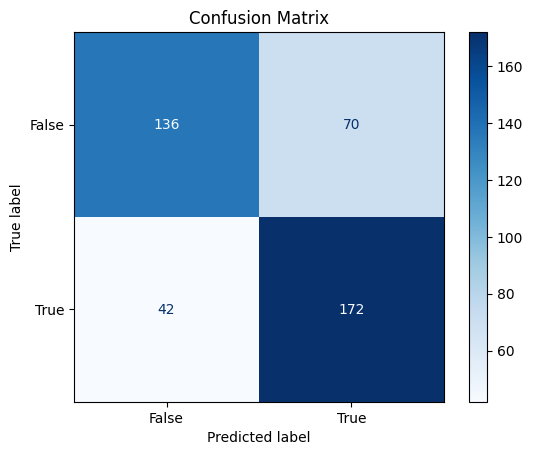

In [6]:
!pip install h5py
!ls

import h5py
import numpy as np # Import numpy and assign it to the alias 'np'


# Load the file from the current directory
file_path = '/content/Covid19FakeNews-2.h5'

# Open the HDF5 file in read mode ('r')
with h5py.File(file_path, 'r') as f:
    input_ids = np.array(f['input_ids'])  # Use input_ids as embeddings
    labels = np.array(f['labels'])  # Load labels


# # Handle NaN values in labels
# # Remove samples with NaN labels
# valid_indices = np.isfinite(labels)  # Find indices where labels are not NaN
# input_ids = input_ids[valid_indices]
# labels = labels[valid_indices]

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(input_ids, labels, test_size=0.2, random_state=42)

# Step 3: Train Logistic Regression
log_reg = LogisticRegression(max_iter=200, solver='saga', penalty='l2', C=1.0)
log_reg.fit(X_train, y_train)

# Step 4: Evaluate the Model
predictions = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"\nModel Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=['False', 'True']))

# Step 5: Display Confusion Matrix
conf_matrix = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['False', 'True'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')


In [7]:
# Extract feature importance
feature_weights = log_reg.coef_[0]  # Weights for the first class

# Show the top 10 most influential features
top_positive_indices = np.argsort(feature_weights)[-10:]  # Top 10 positive weights
top_negative_indices = np.argsort(feature_weights)[:10]  # Top 10 negative weights

print("\nTop 10 Features Predicting 'Real' News:")
print(top_positive_indices)

print("\nTop 10 Features Predicting 'Fake' News:")
print(top_negative_indices)


# Find misclassified samples
misclassified_indices = np.where(predictions != y_test)[0]

# Display a few misclassified examples
print("\nExamples of Misclassified Samples:")
for idx in misclassified_indices[:5]:  # Show up to 5 examples
    print(f"Sample {idx}:")
    print(f"Input IDs: {X_test[idx]}")
    print(f"True Label: {'Fake' if y_test[idx] == 0 else 'Real'}")
    print(f"Predicted Label: {'Fake' if predictions[idx] == 0 else 'Real'}\n")


Top 10 Features Predicting 'Real' News:
[102  77  83  99 103 110 109  71 106  90]

Top 10 Features Predicting 'Fake' News:
[145 120 100  92  88 107 152 133  72 131]

Examples of Misclassified Samples:
Sample 2:
Input IDs: [  101  4366  1024  2634  2211 11326  5467  2013  1001  2522 17258 16147
  1011  5360  3032  2077  2009  2018  1037  2309  2553  1024  7610 16913
  2072  2755  1024  1996 22410 16714  5415 11326  1997  2035  2248  7599
  2069  2006  9388  1018  2011  2043  2676  3572  2018  2042 11156  2408
  1019  2796  2163 16770  1024  1013  1013  1056  1012  2522  1013  1016
 20808  6914 27942   102     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     